In [11]:
from glob import glob
import pandas as pd
import os
import re
import scipy.special
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def load_directory(data_folder):
    sampling_folders = glob(data_folder+"/*")
    sampling_num_interiors = []
    sampling_num_CH = []
    sampling_num_puzzles = []
    sampling_total_num_points = []
    sampling_ids = []

    for folder in  sampling_folders:
        csv_paths = glob(os.path.join(folder,"*.csv"))
        count_puzzles = 0
        folder_puzzles_paths = []
        is_metdata_found = False

        num_interior = None
        num_CH = None

        for csv_path in csv_paths:
            csv_name = os.path.basename(csv_path)

            # Because the first kernel has always tiling, the metadata always starts with a letter 
            # There should be only one, if there many, take the latest (the variables num_interior and num_CH are overrided)
            if re.match("^[a-zA-Z]+.*",csv_name) and not csv_name.startswith("s_"):
                is_metdata_found = True
                df_metadata = pd.read_csv(csv_path)
                counts_roles = df_metadata["role"].value_counts()
                try:
                    num_interior = counts_roles["interior"]
                    # sampling_num_interiors.append()
                except KeyError:
                    num_interior = 0
                    # sampling_num_interiors.append(0)
                
                num_CH = counts_roles["frame"]
                # sampling_num_CH.append(counts_roles["frame"])
            else:
                count_puzzles+=1
        

        if not is_metdata_found:
            raise Exception(f"Cannot find the sampling metadata csv of {folder}")
        
        sampling_num_interiors.append(num_interior)
        sampling_num_CH.append(num_CH)

        sampling_num_puzzles.append(count_puzzles)
        containing_dir = os.path.basename(folder)
        sampling_ids.append(containing_dir)



    df_all_samples = pd.DataFrame({
        "id": sampling_ids,
        "num_interior":sampling_num_interiors,
        "num_CH": sampling_num_CH,
        "num_puzzles":sampling_num_puzzles
    })

    df_all_samples["num_total_points"] = df_all_samples["num_interior"] + df_all_samples["num_CH"]

    # A sampling must create a puzzle, remove all the sampling that were failed
    df_all_samples.drop(df_all_samples[df_all_samples["num_puzzles"] == 0].index, inplace=True)

    return df_all_samples

# Panel A

In [ ]:
df = load_directory(f"../data/paper/panelA")
print(len(df))
df.head(10)

80


,id,num_interior,num_CH,num_puzzles,num_total_points
0,1,0,3,1,3
1,10,0,3,1,3
2,11,0,4,3,4
3,12,0,4,3,4
4,13,1,3,1,4
5,14,1,3,1,4
6,15,0,4,3,4
7,16,0,4,3,4
8,17,0,4,3,4
9,18,0,4,3,4


In [14]:
groupby_A = df.groupby(["num_total_points"],as_index=False).agg({"num_puzzles":["mean","std","max","min","count"]})
groupby_A.head(50)

num_total_points num_puzzles                                
                          mean          std    max   min count
0                3         1.0     0.000000      1     1    10
1                4         2.6     0.843274      3     1    10
2                5         7.4     3.864367     11     3    10
3                6        20.4     6.931410     31    13    10
4                7        99.8    38.932420    155    51    10
5                8       573.6   235.030116    877   173    10
6                9      2208.0   928.889062   3857   935    10
7               10     11633.0  4955.546029  18255  2965    10

In [15]:
print("means " + str(groupby_A.values[:,1].tolist()))
print("std " + str(groupby_A.values[:,2].tolist()))
print("max " + str(groupby_A.values[:,3].tolist()))
print("min " + str(groupby_A.values[:,4].tolist()))

means [1.0, 2.6, 7.4, 20.4, 99.8, 573.6, 2208.0, 11633.0]
std [0.0, 0.8432740427115678, 3.8643671323171835, 6.93140998963735, 38.93242008061319, 235.03011627354388, 928.8890616693088, 4955.5460288896975]
max [1.0, 3.0, 11.0, 31.0, 155.0, 877.0, 3857.0, 18255.0]
min [1.0, 1.0, 3.0, 13.0, 51.0, 173.0, 935.0, 2965.0]


In [ ]:
df_B = load_directory(f"../data/paper/panelB")
print(len(df_B))
groupby_B = df_B.groupby(["num_total_points"],as_index=False).agg({"num_puzzles":["mean","std","max","min","count"]})
groupby_B.head(50)

80


num_total_points num_puzzles                         
                          mean  std    max    min count
0                3         1.0  0.0      1      1    10
1                4         3.0  0.0      3      3    10
2                5        11.0  0.0     11     11    10
3                6        45.0  0.0     45     45    10
4                7       197.0  0.0    197    197    10
5                8       903.0  0.0    903    903    10
6                9      4279.0  0.0   4279   4279    10
7               10     20793.0  0.0  20793  20793    10

In [17]:
print("means " + str(groupby_B.values[:,1].tolist()))
print("std " + str(groupby_B.values[:,2].tolist()))
print("max " + str(groupby_B.values[:,3].tolist()))
print("min " + str(groupby_B.values[:,4].tolist()))

means [1.0, 3.0, 11.0, 45.0, 197.0, 903.0, 4279.0, 20793.0]
std [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
max [1.0, 3.0, 11.0, 45.0, 197.0, 903.0, 4279.0, 20793.0]
min [1.0, 3.0, 11.0, 45.0, 197.0, 903.0, 4279.0, 20793.0]


In [18]:
def binomial_choose(n,k):
    return scipy.special.comb(n,k)

def num_ways_noncrossing_diagonals(n,k):
    return binomial_choose(n-3,k)*binomial_choose(n+k-1,k)/(k+1)

def num_partitions_non_interior(n):
    sum_ = 1 # without diagonals

    # passing 1,..., n-3 diagonals
    for k in range(1,n-2,1):
        sum_ += num_ways_noncrossing_diagonals(n,k)
    
    return sum_

assert num_partitions_non_interior(4) == 3 
assert num_partitions_non_interior(5) == 11
assert num_partitions_non_interior(6) == 45
assert num_partitions_non_interior(7) == 197
assert num_partitions_non_interior(8) == 903
assert num_partitions_non_interior(9) == 4279
assert num_partitions_non_interior(10) == 20793


# Plotting Graphs together

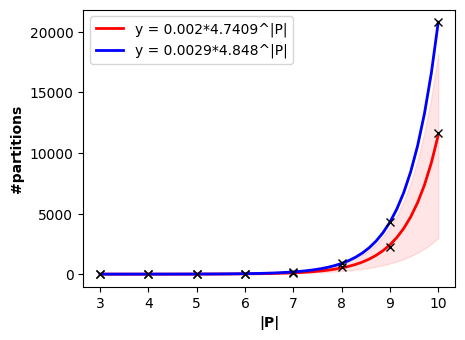

In [19]:
total_num_A = groupby_A.values[:,0]
means_A = groupby_A.values[:,1]
stds_A = groupby_A.values[:,2]
max_A = groupby_A.values[:,3]
min_A = groupby_A.values[:,4]


total_num_h_p = groupby_B.values[:,0]
means_h_p = groupby_B.values[:,1]
stds_h_p = groupby_B.values[:,2]
max_h_p = groupby_B.values[:,3]
min_h_p = groupby_B.values[:,4]

plt.figure(figsize=(4.8,3.6))
ax = plt.subplot()


sampling_points_A = np.linspace(total_num_A[0],total_num_A[-1])
c =  4.7409
a = 0.0020
fitted_values_A = a*np.power(c,sampling_points_A)
# Plot the exponential fit
ax.plot(sampling_points_A, fitted_values_A, 'r-', label=f'y = {a}*{c}^|P|', linewidth=2)
ax.plot(total_num_A,means_A,color="None",marker="x",markeredgecolor="black")

A_max_a = 0.0034
A_max_c = 4.7082
A_min_a = 0.0148 
A_min_c = 3.3916
fitted_values_A_max = A_max_a*np.power(A_max_c,sampling_points_A)
fitted_values_A_min = A_min_a*np.power(A_min_c,sampling_points_A)
ax.fill_between(sampling_points_A,fitted_values_A_min,fitted_values_A_max,color="r",alpha=0.1)

sampling_points_h_p = np.linspace(total_num_h_p[0],total_num_h_p[-1])
c =  4.8480
a = 0.0029
fitted_values_h_p = a*np.power(c,sampling_points_h_p)
# Plot the exponential fit
ax.plot(sampling_points_h_p, fitted_values_h_p, 'b-', label=f'y = {a}*{c}^|P|', linewidth=2)
ax.fill_between(sampling_points_h_p,fitted_values_h_p,fitted_values_h_p,color="b",alpha=0.1)
ax.plot(total_num_h_p,means_h_p,color="None",marker="x",markeredgecolor="black")

ax.set_xticks(np.arange(total_num_h_p[0],total_num_h_p[-1]+1))
ax.set_xlabel("|P|",fontweight="bold")
ax.set_ylabel("#partitions",fontweight="bold")

ax.legend(loc="upper left")

plt.show()

# Panel B*

In [ ]:
df_B_plus = load_directory(f"../data/paper/panelB_+")
print(len(df_B_plus))
groupby_B_plus = df_B_plus.groupby(["num_interior","num_CH"],as_index=False).agg({"num_puzzles":["mean","std","max","min","count"]})
groupby_B_plus.head(50)

50


num_interior num_CH num_puzzles                           
                             mean        std  max  min count
0            0      7       197.0   0.000000  197  197    10
1            1      6       131.0  19.595918  155  107    10
2            2      5        94.6  23.490897  125   61    10
3            3      4        75.8  25.424398  123   35    10
4            4      3        63.4  23.566455  117   29    10

In [21]:
print("means " + str(groupby_B_plus.values[:,2].tolist()))
print("std " + str(groupby_B_plus.values[:,3].tolist()))

means [197.0, 131.0, 94.6, 75.8, 63.4]
std [0.0, 19.595917942265423, 23.490896581914924, 25.424397731313128, 23.56645450163808]


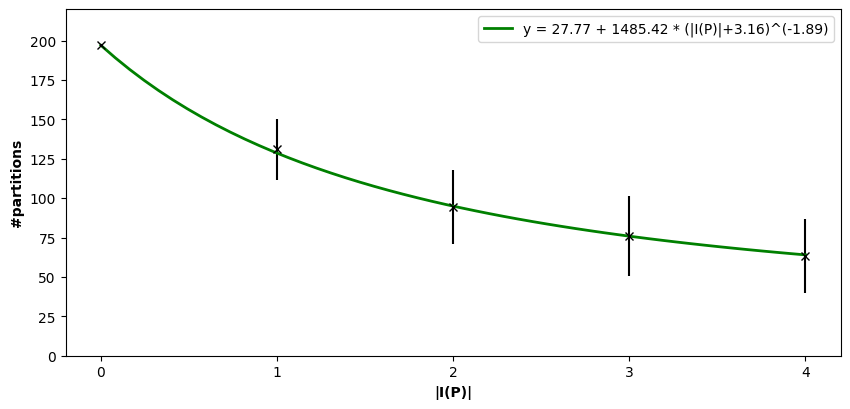

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Given values
means = np.array([197.0, 131.0, 94.6, 75.8, 63.4])
stds = np.array([0.0, 19.595917942265423, 23.49089658191492, 25.424397731313125, 23.56645450163808])

num_of_ch = np.arange(len(means)) #+ 3

# Set figure size (width, height in inches)
plt.figure(figsize=(10,10*9/20))

# Plot the original data with error bars
ax = plt.subplot()

ax.errorbar(range(len(means)),means,yerr=stds,marker="x",color="None",markeredgecolor="black",ecolor="black")

# Evaluate the fitted function at the x values
start_sampling = 0
end_sampling = 4
sampling_points = np.linspace(start_sampling,end_sampling)
a = 27.7675
b = 1485.4205
c = -3.1632
k = 1.8857

fitted_values = a+b*np.power(sampling_points-c,-k)
ax.plot(sampling_points, fitted_values, 'g-', label=f'y = {a:.2f} + {b:.2f} * (|I(P)|+{-c:.2f})^(-{k:.2f})', linewidth=2)

# Set labels with bold font
ax.set_xlabel("|I(P)|", fontweight='bold')
ax.set_ylabel("#partitions", fontweight='bold')
ax.set_xticks(np.arange(len(means)))
# ax.set_xlim((3,9))
ax.set_ylim((0,220))


# Add a legend
ax.legend(loc="upper right")

# Show the plot
plt.show()
